
# Analyse patient-level avec CATEGORY (= statut variant)

- CATEGORY = "no_variants" / "at_least_one_variant"
- Analyses descriptives déjà faites, maintenant stratifiées par mention d'un variant

In [37]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import scipy.stats as stats
import os

In [38]:
plt.close("all")
sns.set_theme()
palette = sns.color_palette("Set2")

## 1. Chargement des données & préparation minimale

In [39]:
OUTPUT_PATH = "output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [40]:
df = pd.read_csv("simulated_patient_level_df.csv", sep=";")

In [41]:
def add_variant_presence(df, col="n_variants"):
    """
    Crée une colonne 'variant_presence' à partir de n_variants :
    - si n_variants >= 1 → 'at_least_one_variant'
    - sinon → 'no_variants'
    """
    df["variant_presence"] = df[col].fillna(0).astype(float).apply(
        lambda x: "at_least_one_variant" if x >= 1 else "no_variants"
    )
    return df

df = add_variant_presence(df)

In [42]:
for col in ["first_doc_date", "last_doc_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

In [43]:
num_cols = [
    "n_documents",
    "total_words",
    "patient_age_first",
    "patient_age_last",
    "followup_days",
    "docs_per_year",
    "n_hpo_unique",
    "n_hpo_full_list",
]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

In [44]:
def parse_list_or_keep(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str):
        s = x.strip()
        if s in ("", "[]"):
            return []
        try:
            val = ast.literal_eval(s)
            if isinstance(val, list):
                return val
            return [val]
        except (ValueError, SyntaxError):
            return [x]
    return [x]

In [45]:
for col in ["HPO_full_list", "HPO_unique_list"]:
    if col in df.columns:
        df[col] = df[col].apply(parse_list_or_keep)

## 2. Variable CATEGORY (statut variant)

In [46]:
CATEGORY = "variant_presence"
print(df[CATEGORY].value_counts())

variant_presence
at_least_one_variant    843
no_variants             157
Name: count, dtype: int64


Palette de couleurs par catégorie

In [47]:
cat_levels = df[CATEGORY].dropna().unique()
color_map = dict(zip(cat_levels, palette[: len(cat_levels)]))
color_map

{'no_variants': (0.4, 0.7607843137254902, 0.6470588235294118),
 'at_least_one_variant': (0.9882352941176471,
  0.5529411764705883,
  0.3843137254901961)}


## 3. Âge à l'arrivée au service

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/405457333.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df_age.groupby(["age_bin", "cat"]).size().unstack(fill_value=0)
/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/405457333.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{abs(int(t))}%" for t in xt])


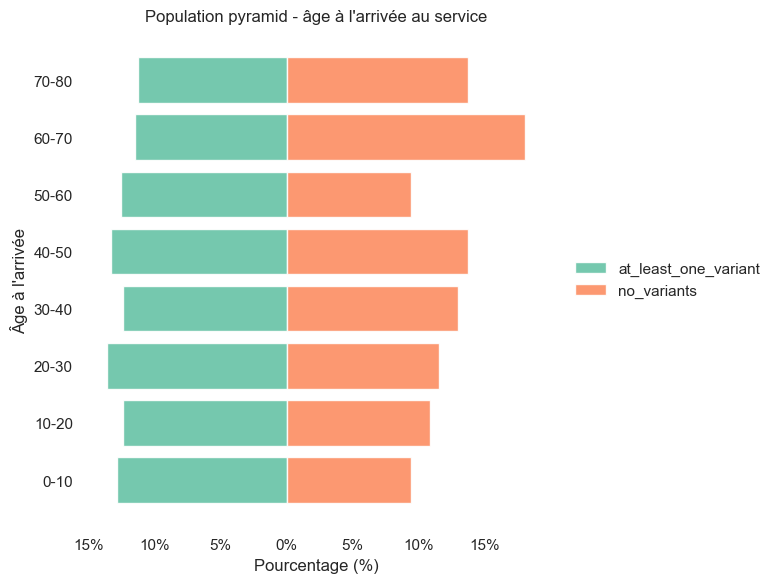

In [48]:
age = df["patient_age_first"]
cat = df[CATEGORY]

bins = np.arange(0, 85, 10)
labels = [f"{i}-{i+10}" for i in bins[:-1]]

df_age = pd.DataFrame({
    "age": age,
    "cat": cat
}).dropna()

df_age["age_bin"] = pd.cut(
    df_age["age"],
    bins=bins,
    labels=labels,
    right=False,
    include_lowest=True
)

# comptage
tab = df_age.groupby(["age_bin", "cat"]).size().unstack(fill_value=0)

# conversion en % du total catégorie
tab_pct = tab.div(tab.sum(axis=0), axis=1) * 100

# inversion pour un côté du plot
tab_plot = tab_pct.copy()
tab_plot.iloc[:, 0] = -tab_plot.iloc[:, 0]   # première catégorie en négatif

fig, ax = plt.subplots(figsize=(8,6), facecolor="white")

cats = tab_plot.columns
colors = sns.color_palette("Set2", len(cats))

# bars
for i, c in enumerate(cats):
    ax.barh(tab_plot.index, tab_plot[c], color=colors[i], alpha=0.9, label=c)

# labels axes
ax.set_xlabel("Pourcentage (%)")
ax.set_ylabel("Âge à l'arrivée")
ax.set_title("Population pyramid - âge à l'arrivée au service", pad=10)

# ticks en pourcentage (signés -> absolus)
xt = ax.get_xticks()
ax.set_xticklabels([f"{abs(int(t))}%" for t in xt])

# --- suppression du fond / grille ---
ax.set_facecolor("white")
ax.grid(True)

# --- garder seulement axes bas + gauche (abscisse/ordonnée) ---
for side in ["top", "right"]:
    ax.spines[side].set_visible(False)
# left & bottom restent visibles par défaut

# légende à droite
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "age_at_first_doc_pyramid.png", dpi=300)
plt.show()
plt.close()

Tailles: n1=843, n2=157
Shapiro-Wilk p-values: g1=0.0000, g2=0.0000
Levene p-value: 0.7888
→ Test non-paramétrique Mann–Whitney
Statistique = 59546.000, p = 0.04602


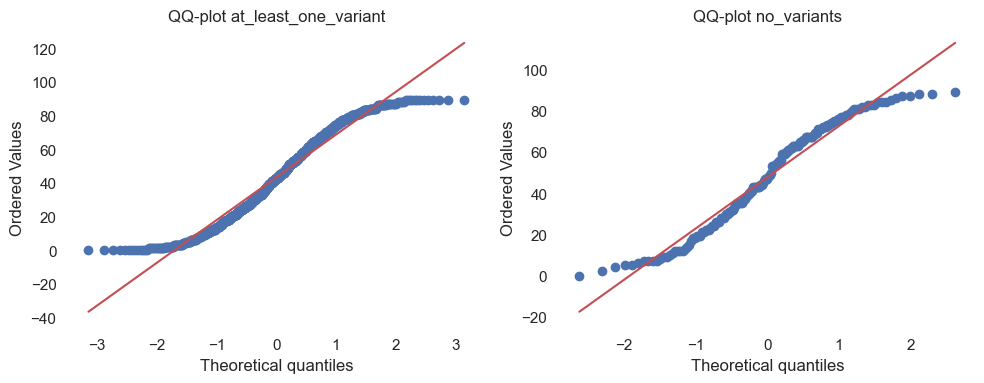

In [49]:
group1 = df[df[CATEGORY] == cats[0]]["patient_age_first"].dropna()
group2 = df[df[CATEGORY] == cats[1]]["patient_age_first"].dropna()

print(f"Tailles: n1={len(group1)}, n2={len(group2)}")

# === Test normalité : Shapiro-Wilk ===
sh_p1 = shapiro(group1)[1]
sh_p2 = shapiro(group2)[1]
print(f"Shapiro-Wilk p-values: g1={sh_p1:.4f}, g2={sh_p2:.4f}")

normal = (sh_p1 > 0.05) and (sh_p2 > 0.05)

# === Test homogénéité des variances : Levene ===
lev_p = levene(group1, group2)[1]
print(f"Levene p-value: {lev_p:.4f}")

equal_var = lev_p > 0.05

# === Choix du test ===
if normal:
    if equal_var:
        print("→ Test paramétrique Student (variances égales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
    else:
        print("→ Test paramétrique Welch (variances inégales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
else:
    print("→ Test non-paramétrique Mann–Whitney")
    t_stat, p_val = mannwhitneyu(group1, group2, alternative="two-sided")

print(f"Statistique = {t_stat:.3f}, p = {p_val:.5f}")

# === QQ-plots ===
fig, axs = plt.subplots(1, 2, figsize=(10,4))

stats.probplot(group1, plot=axs[0])
axs[0].set_title(f"QQ-plot {cats[0]}")

stats.probplot(group2, plot=axs[1])
axs[1].set_title(f"QQ-plot {cats[1]}")

# --- suppression fond, grille, cadre pour chaque subplot ---
for ax in axs:
    ax.set_facecolor("white")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "age_at_first_doc_qqplot", dpi=300)
plt.show()
plt.close()


## 4. Nombre de documents par patient

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/2008981166.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


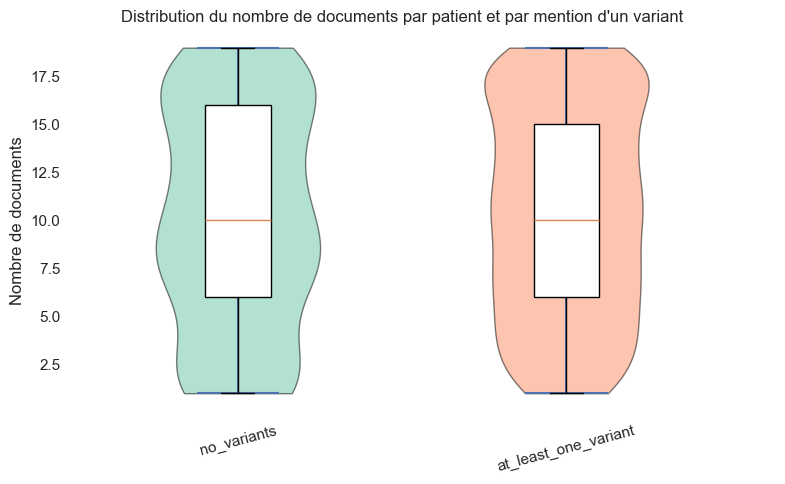

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))

positions = np.arange(len(cat_levels))
data = [df[df[CATEGORY] == cat]["n_documents"].dropna() for cat in cat_levels]

bp = ax.violinplot(data, positions=positions, showmeans=False, showmedians=False)
for body, cat in zip(bp["bodies"], cat_levels):
    body.set_facecolor(color_map[cat])
    body.set_edgecolor("black")
    body.set_alpha(0.5)

bp_box = ax.boxplot(
    data,
    positions=positions,
    widths=0.2,
    patch_artist=True,
    showfliers=True,
)
for patch, cat in zip(bp_box["boxes"], cat_levels):
    patch.set_facecolor("white")
    patch.set_edgecolor("black")

ax.set_xticks(positions)
ax.set_xticklabels(cat_levels, rotation=15)
ax.set_ylabel("Nombre de documents")
ax.set_title("Distribution du nombre de documents par patient et par mention d'un variant")

# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "distrib_nb_docs_per_patient_and_per_var_presence.png", dpi=300)
plt.show()
plt.close()

Tailles: n1=843, n2=157
Shapiro-Wilk p-values: g1=0.0000, g2=0.0000
Levene p-value: 0.3382
→ Test non-paramétrique Mann–Whitney
Statistique = 68310.500, p = 0.51999


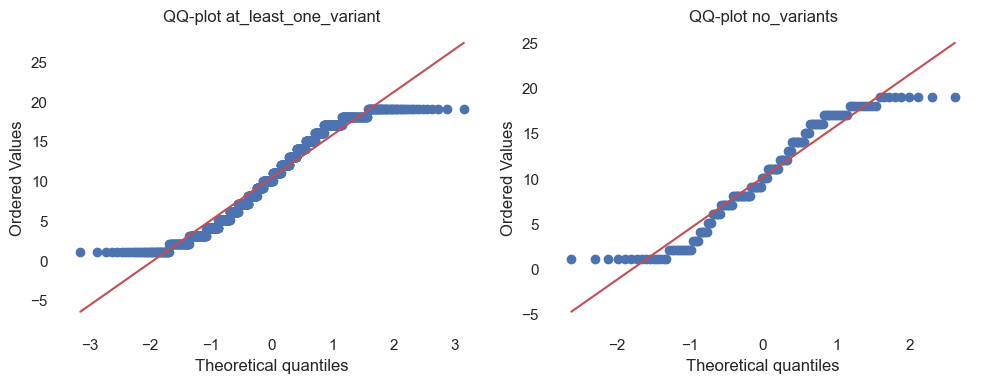

In [51]:
group1 = df[df[CATEGORY] == cats[0]]["n_documents"].dropna()
group2 = df[df[CATEGORY] == cats[1]]["n_documents"].dropna()

print(f"Tailles: n1={len(group1)}, n2={len(group2)}")

# === Test normalité : Shapiro-Wilk ===
sh_p1 = shapiro(group1)[1]
sh_p2 = shapiro(group2)[1]
print(f"Shapiro-Wilk p-values: g1={sh_p1:.4f}, g2={sh_p2:.4f}")

normal = (sh_p1 > 0.05) and (sh_p2 > 0.05)

# === Test homogénéité des variances : Levene ===
lev_p = levene(group1, group2)[1]
print(f"Levene p-value: {lev_p:.4f}")

equal_var = lev_p > 0.05

# === Choix du test ===
if normal:
    if equal_var:
        print("→ Test paramétrique Student (variances égales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
    else:
        print("→ Test paramétrique Welch (variances inégales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
else:
    print("→ Test non-paramétrique Mann–Whitney")
    t_stat, p_val = mannwhitneyu(group1, group2, alternative="two-sided")

print(f"Statistique = {t_stat:.3f}, p = {p_val:.5f}")

# === QQ-plots ===
fig, axs = plt.subplots(1, 2, figsize=(10,4))

stats.probplot(group1, plot=axs[0])
axs[0].set_title(f"QQ-plot {cats[0]}")

stats.probplot(group2, plot=axs[1])
axs[1].set_title(f"QQ-plot {cats[1]}")

# --- suppression fond, grille, cadre pour chaque subplot ---
for ax in axs:
    ax.set_facecolor("white")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "n_documents_per_variant_presence_qqplot", dpi=300)
plt.show()
plt.close()


## 5. Nombre total de mots par patient

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/68566896.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


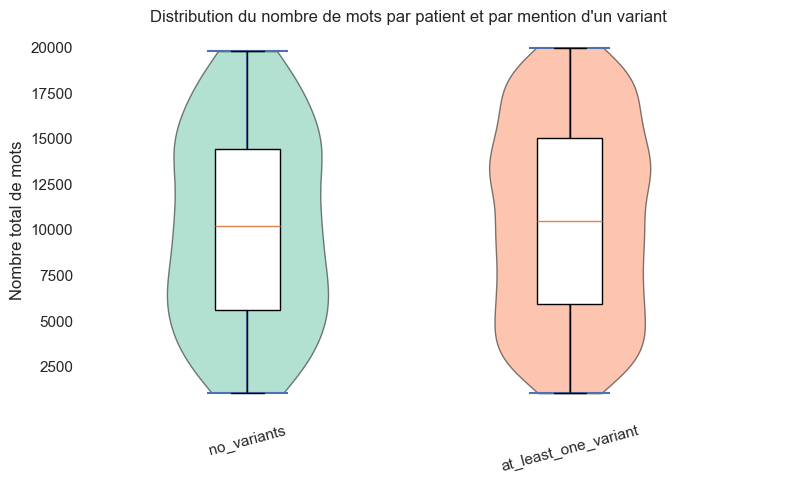

In [52]:
fig, ax = plt.subplots(figsize=(8, 5))

data = [df[df[CATEGORY] == cat]["total_words"].dropna() for cat in cat_levels]

bp = ax.violinplot(data, positions=positions, showmeans=False, showmedians=False)
for body, cat in zip(bp["bodies"], cat_levels):
    body.set_facecolor(color_map[cat])
    body.set_edgecolor("black")
    body.set_alpha(0.5)

bp_box = ax.boxplot(
    data,
    positions=positions,
    widths=0.2,
    patch_artist=True,
    showfliers=True,
)
for patch in bp_box["boxes"]:
    patch.set_facecolor("white")
    patch.set_edgecolor("black")

ax.set_xticks(positions)
ax.set_xticklabels(cat_levels, rotation=15)
ax.set_ylabel("Nombre total de mots")
ax.set_title("Distribution du nombre de mots par patient et par mention d'un variant")

# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "n_words_per_patient_and_per_presence_variant.png", dpi=300)
plt.show()
plt.close()

Tailles: n1=843, n2=157
Shapiro-Wilk p-values: g1=0.0000, g2=0.0002
Levene p-value: 0.7333
→ Test non-paramétrique Mann–Whitney
Statistique = 69302.500, p = 0.34673


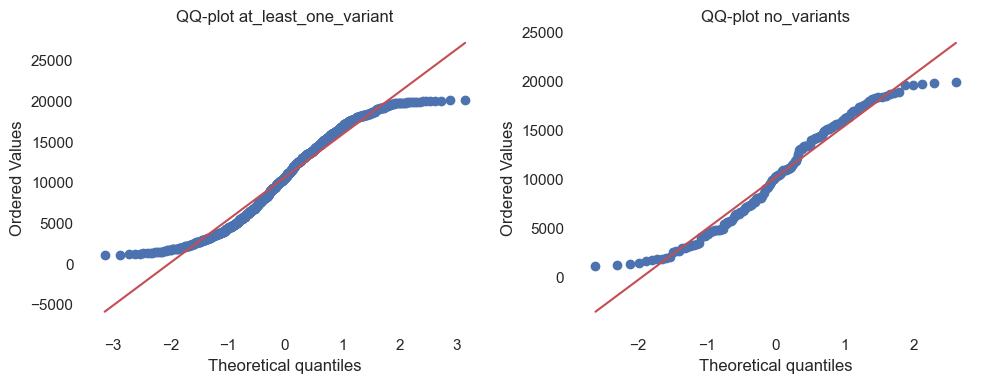

In [53]:
group1 = df[df[CATEGORY] == cats[0]]["total_words"].dropna()
group2 = df[df[CATEGORY] == cats[1]]["total_words"].dropna()

print(f"Tailles: n1={len(group1)}, n2={len(group2)}")

# === Test normalité : Shapiro-Wilk ===
sh_p1 = shapiro(group1)[1]
sh_p2 = shapiro(group2)[1]
print(f"Shapiro-Wilk p-values: g1={sh_p1:.4f}, g2={sh_p2:.4f}")

normal = (sh_p1 > 0.05) and (sh_p2 > 0.05)

# === Test homogénéité des variances : Levene ===
lev_p = levene(group1, group2)[1]
print(f"Levene p-value: {lev_p:.4f}")

equal_var = lev_p > 0.05

# === Choix du test ===
if normal:
    if equal_var:
        print("→ Test paramétrique Student (variances égales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
    else:
        print("→ Test paramétrique Welch (variances inégales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
else:
    print("→ Test non-paramétrique Mann–Whitney")
    t_stat, p_val = mannwhitneyu(group1, group2, alternative="two-sided")

print(f"Statistique = {t_stat:.3f}, p = {p_val:.5f}")

# === QQ-plots ===
fig, axs = plt.subplots(1, 2, figsize=(10,4))

stats.probplot(group1, plot=axs[0])
axs[0].set_title(f"QQ-plot {cats[0]}")

stats.probplot(group2, plot=axs[1])
axs[1].set_title(f"QQ-plot {cats[1]}")

# --- suppression fond, grille, cadre pour chaque subplot ---
for ax in axs:
    ax.set_facecolor("white")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "n_words_per_variant_presence_qqplot", dpi=300)
plt.show()
plt.close()



## 6. Temps de suivi (années)

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/3769586433.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df_suiv.groupby(["follow_bin","cat"]).size().unstack(fill_value=0)
/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/3769586433.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{abs(int(t))}%" for t in xt])


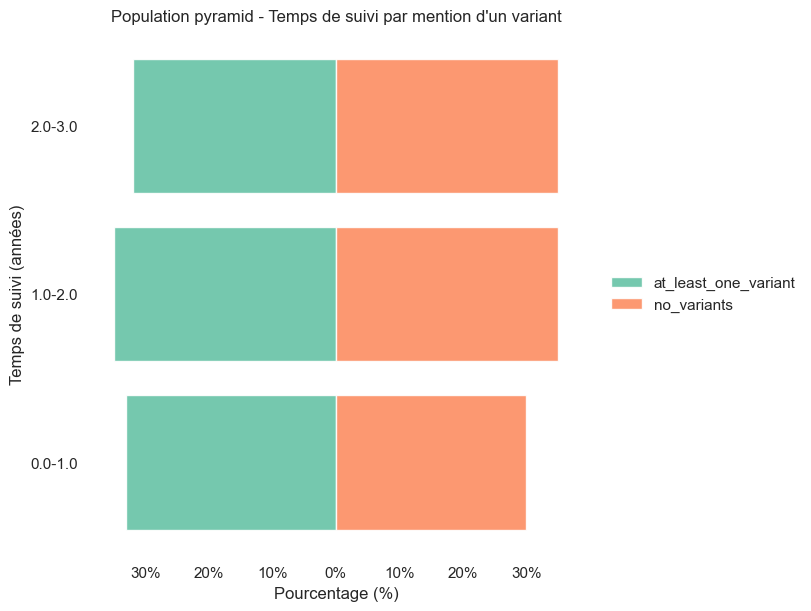

In [54]:
# =========================
# Population pyramid du temps de suivi
# =========================

x_years = (df["followup_days"] / 365.25).dropna()
cat = df[CATEGORY]

# choix des bins
max_follow = np.ceil(x_years.max())
bins = np.arange(0, max_follow+1, 1)   # bins annuels
labels = [f"{i}-{i+1}" for i in bins[:-1]]

df_suiv = pd.DataFrame({"follow": x_years, "cat": cat}).dropna()
df_suiv["follow_bin"] = pd.cut(df_suiv["follow"], bins=bins, labels=labels, right=False, include_lowest=True)

# comptage par classe et catégorie
tab = df_suiv.groupby(["follow_bin","cat"]).size().unstack(fill_value=0)

# passage en %
tab_pct = tab.div(tab.sum(axis=0), axis=1) * 100

tab_plot = tab_pct.copy()
tab_plot.iloc[:,0] = -tab_plot.iloc[:,0]  # inversion pour pyramide

# --- PLot pyramide ---
fig, ax = plt.subplots(figsize=(8,6), facecolor="white", constrained_layout=True)

cats = tab_plot.columns
colors = sns.color_palette("Set2", len(cats))

for i, c in enumerate(cats):
    ax.barh(tab_plot.index, tab_plot[c], color=colors[i], alpha=0.9, label=c)

ax.set_xlabel("Pourcentage (%)")
ax.set_ylabel("Temps de suivi (années)")
ax.set_title("Population pyramid - Temps de suivi par mention d'un variant", pad=10)

# ticks en pourcentage absolu
xt = ax.get_xticks()
ax.set_xticklabels([f"{abs(int(t))}%" for t in xt])

# --- suppression fond / grille / cadres ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# --- légende à droite ---
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)

plt.savefig(OUTPUT_PATH + "time_follow_per_variant_presence_population_pyramid.png", dpi=300)
plt.show()
plt.close()


Tailles: n1=843, n2=157
Shapiro-Wilk p-values: g1=0.0000, g2=0.0001
Levene p-value: 0.8238
→ Test non-paramétrique Mann–Whitney
Statistique = 64418.000, p = 0.59695


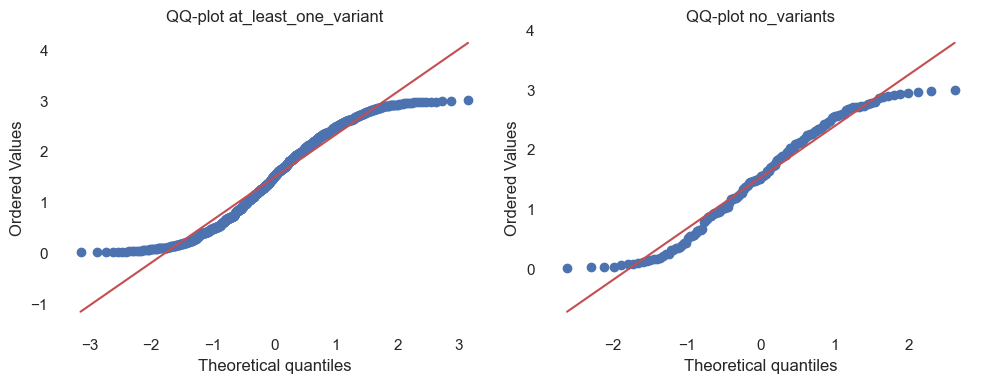

In [55]:
group1 = df_suiv[df_suiv["cat"] == cats[0]]["follow"].dropna()
group2 = df_suiv[df_suiv["cat"] == cats[1]]["follow"].dropna()

print(f"Tailles: n1={len(group1)}, n2={len(group2)}")

# === Test normalité : Shapiro-Wilk ===
sh_p1 = shapiro(group1)[1]
sh_p2 = shapiro(group2)[1]
print(f"Shapiro-Wilk p-values: g1={sh_p1:.4f}, g2={sh_p2:.4f}")

normal = (sh_p1 > 0.05) and (sh_p2 > 0.05)

# === Test homogénéité des variances : Levene ===
lev_p = levene(group1, group2)[1]
print(f"Levene p-value: {lev_p:.4f}")

equal_var = lev_p > 0.05

# === Choix du test ===
if normal:
    if equal_var:
        print("→ Test paramétrique Student (variances égales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=True)
    else:
        print("→ Test paramétrique Welch (variances inégales)")
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
else:
    print("→ Test non-paramétrique Mann–Whitney")
    t_stat, p_val = mannwhitneyu(group1, group2, alternative="two-sided")

print(f"Statistique = {t_stat:.3f}, p = {p_val:.5f}")

# === QQ-plots ===
fig, axs = plt.subplots(1, 2, figsize=(10,4))

stats.probplot(group1, plot=axs[0])
axs[0].set_title(f"QQ-plot {cats[0]}")

stats.probplot(group2, plot=axs[1])
axs[1].set_title(f"QQ-plot {cats[1]}")

# --- suppression fond, grille, cadre pour chaque subplot ---
for ax in axs:
    ax.set_facecolor("white")
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + "time_follow_per_patient_and_variant_presence_qqplot.png", dpi=300)
plt.show()
plt.close()

KDE (via pandas)

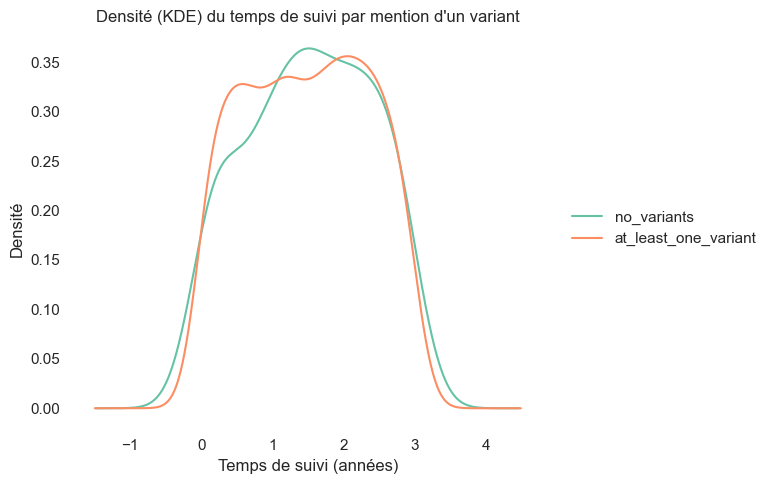

In [56]:
fig, ax = plt.subplots(figsize=(8, 5))
for cat in cat_levels:
    subset = x_years[df[CATEGORY] == cat].dropna()
    subset.plot(kind="kde", ax=ax, label=cat, color=color_map[cat])
ax.set_title("Densité (KDE) du temps de suivi par mention d'un variant")
ax.set_xlabel("Temps de suivi (années)")
ax.set_ylabel("Densité")
ax.legend()
plt.tight_layout()

# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "time_follow_per_patient_and_presence_variant_densitykde.png", dpi=300)
plt.show()
plt.close()


## 7. Nombre de termes HPO uniques et totaux par patient


HPO uniques

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/1233290441.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


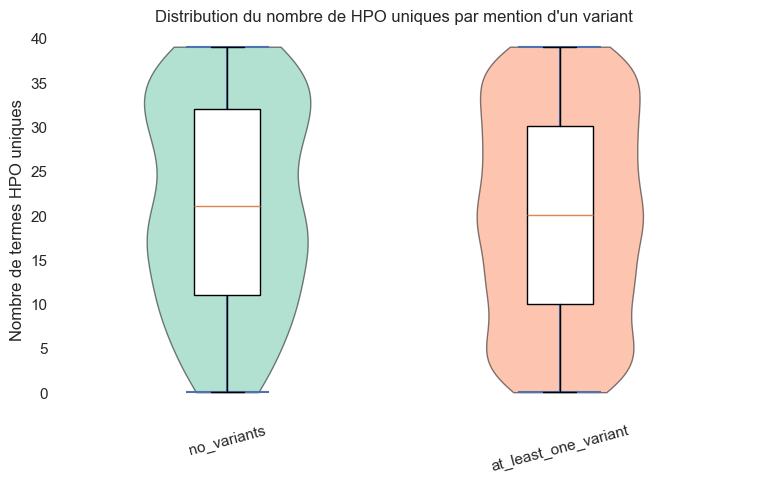

In [57]:
fig, ax = plt.subplots(figsize=(8, 5))
data = [df[df[CATEGORY] == cat]["n_hpo_unique"].dropna() for cat in cat_levels]
bp = ax.violinplot(data, positions=positions, showmeans=False, showmedians=False)
for body, cat in zip(bp["bodies"], cat_levels):
    body.set_facecolor(color_map[cat])
    body.set_edgecolor("black")
    body.set_alpha(0.5)

bp_box = ax.boxplot(
    data,
    positions=positions,
    widths=0.2,
    patch_artist=True,
    showfliers=True,
)
for patch in bp_box["boxes"]:
    patch.set_facecolor("white")
    patch.set_edgecolor("black")

ax.set_xticks(positions)
ax.set_xticklabels(cat_levels, rotation=15)
ax.set_ylabel("Nombre de termes HPO uniques")
ax.set_title("Distribution du nombre de HPO uniques par mention d'un variant")
plt.tight_layout()
# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "n_unique_hpo_per_variant_presence_distrib.png", dpi=300)
plt.show()
plt.close()

HPO totaux (full list)

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/2537733156.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


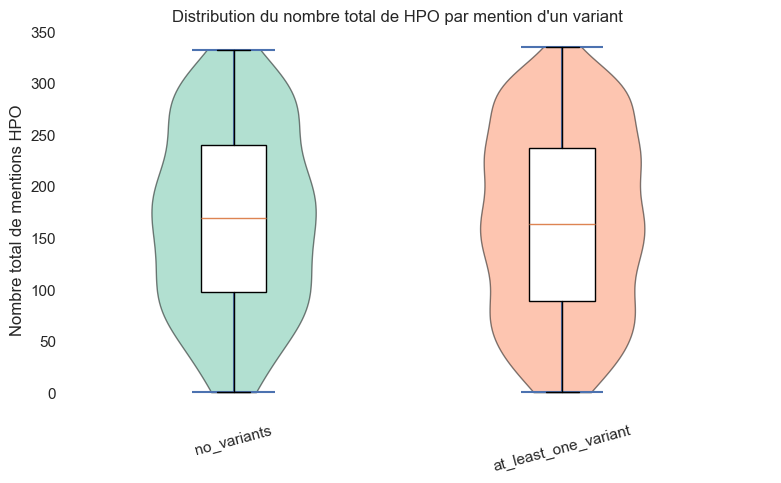

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
data = [df[df[CATEGORY] == cat]["n_hpo_full_list"].dropna() for cat in cat_levels]
bp = ax.violinplot(data, positions=positions, showmeans=False, showmedians=False)
for body, cat in zip(bp["bodies"], cat_levels):
    body.set_facecolor(color_map[cat])
    body.set_edgecolor("black")
    body.set_alpha(0.5)

bp_box = ax.boxplot(
    data,
    positions=positions,
    widths=0.2,
    patch_artist=True,
    showfliers=True,
)
for patch in bp_box["boxes"]:
    patch.set_facecolor("white")
    patch.set_edgecolor("black")

ax.set_xticks(positions)
ax.set_xticklabels(cat_levels, rotation=15)
ax.set_ylabel("Nombre total de mentions HPO")
ax.set_title("Distribution du nombre total de HPO par mention d'un variant")
plt.tight_layout()
# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "n_full_hpo_per_variant_presence_distrib.png", dpi=300)
plt.show()
plt.close()


## 8. Entropie & redondance HPO

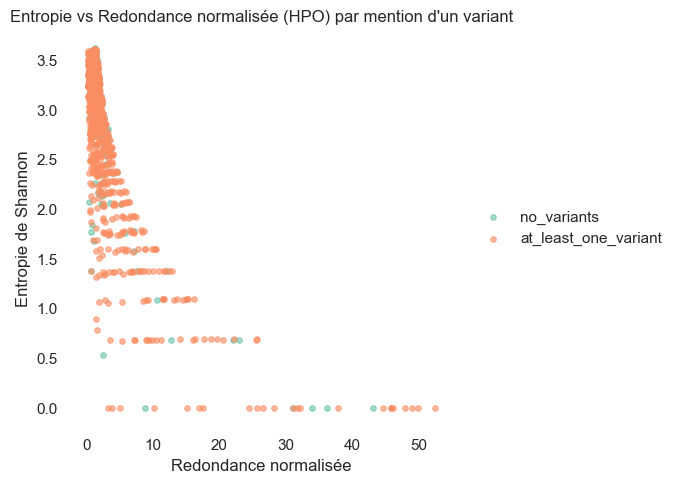

In [59]:
from collections import Counter

def shannon_entropy(full_list):
    if not full_list:
        return 0.0
    counts = np.array(list(Counter(full_list).values()))
    p = counts / counts.sum()
    return float(-(p * np.log(p)).sum())

df["entropy_shannon"] = df["HPO_full_list"].apply(shannon_entropy)

df["redundancy_ratio"] = df["n_hpo_full_list"] / df["n_hpo_unique"].replace(0, np.nan)
df["redundancy_norm"] = df["redundancy_ratio"] / np.log(
    df["n_hpo_full_list"].replace(0, np.nan)
)

fig, ax = plt.subplots(figsize=(7, 5))
for cat in cat_levels:
    sub = df[df[CATEGORY] == cat]
    ax.scatter(
        sub["redundancy_norm"],
        sub["entropy_shannon"],
        alpha=0.6,
        label=cat,
        s=15,
        color=color_map[cat],
    )

ax.set_xlabel("Redondance normalisée")
ax.set_ylabel("Entropie de Shannon")
ax.set_title("Entropie vs Redondance normalisée (HPO) par mention d'un variant")
ax.legend()
plt.tight_layout()
# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "entropy_vs_redundancy_normalised_hpo_per_variant_presence.png", dpi=300)
plt.show()
plt.close()

KDE (via pandas) de l'entropie

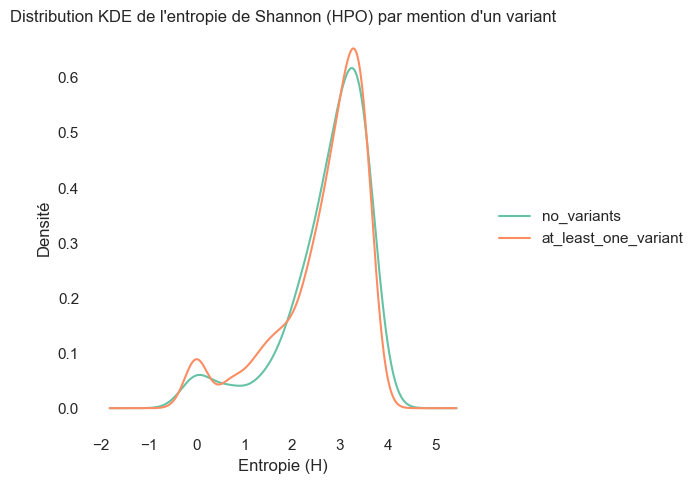

In [60]:
fig, ax = plt.subplots(figsize=(7, 5))
for cat in cat_levels:
    sub = df[df[CATEGORY] == cat]["entropy_shannon"].replace([np.inf, -np.inf], np.nan).dropna()
    if len(sub) == 0:
        continue
    sub.plot(kind="kde", ax=ax, label=cat, color=color_map[cat])

ax.set_title("Distribution KDE de l'entropie de Shannon (HPO) par mention d'un variant")
ax.set_xlabel("Entropie (H)")
ax.set_ylabel("Densité")
ax.legend()
plt.tight_layout()
# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "shannon_entropy_full_list_per_variant_presence_kde.png", dpi=300)
plt.show()
plt.close()

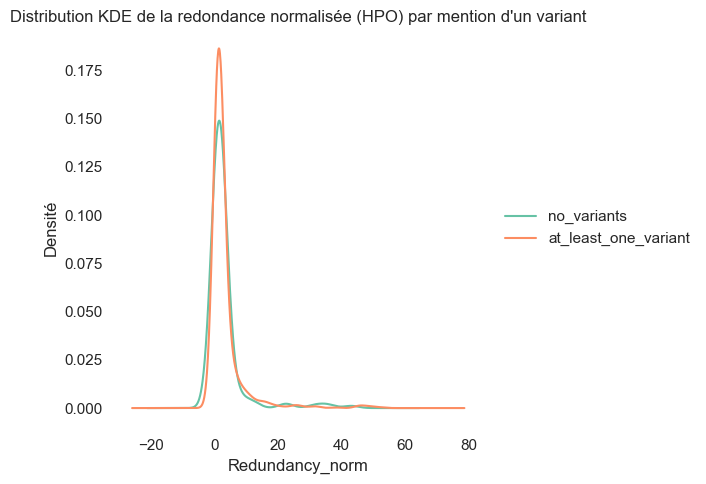

In [61]:
# KDE du taux de redondance normalisé
fig, ax = plt.subplots(figsize=(7, 5))
for cat in cat_levels:
    sub = df[df[CATEGORY] == cat]["redundancy_norm"].replace([np.inf, -np.inf], np.nan).dropna()
    if len(sub) == 0:
        continue
    sub.plot(kind="kde", ax=ax, label=cat, color=color_map[cat])

ax.set_title("Distribution KDE de la redondance normalisée (HPO) par mention d'un variant")
ax.set_xlabel("Redundancy_norm")
ax.set_ylabel("Densité")
ax.legend()
plt.tight_layout()
# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "redundancy_normalised_per_variant_presence_kde.png", dpi=300)
plt.show()
plt.close()

## Charge de patient au cours du temps par présence de variants

/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/2632576540.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = daily_load.resample(freq).mean()
/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/2632576540.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = daily_load.resample(freq).mean()
/var/folders/6n/hw7c94m14pn9syslmn86py080000gq/T/ipykernel_92499/2632576540.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = daily_load.resample(freq).mean()


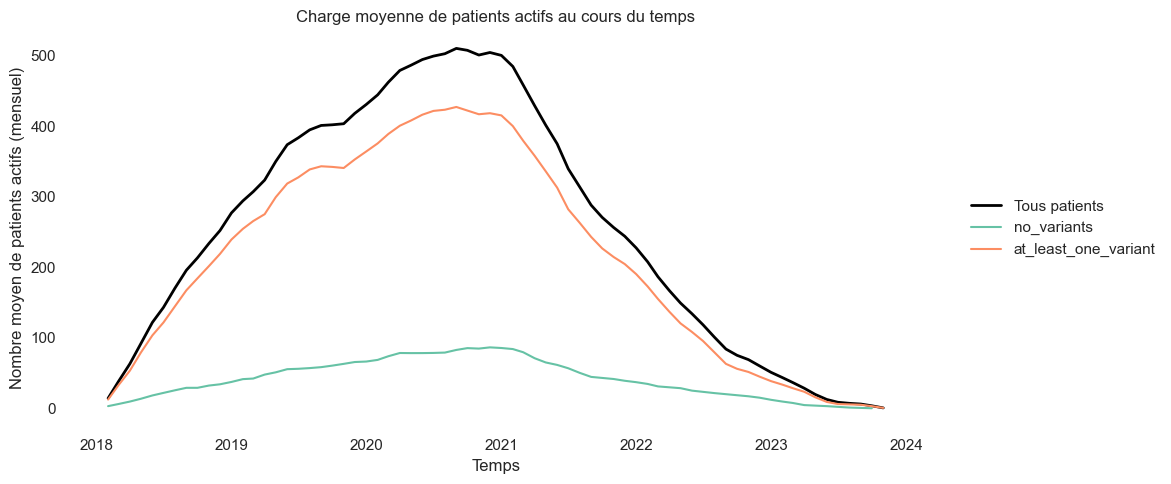

In [62]:
def build_patient_load_series(df_patients, freq="M", inclusive_last=True):
    start_events = (
        df_patients[["first_doc_date"]]
        .rename(columns={"first_doc_date": "date"})
        .assign(delta=1)
    )

    end_dates = df_patients["last_doc_date"]
    if inclusive_last:
        end_dates = end_dates + pd.Timedelta(days=1)

    end_events = end_dates.to_frame(name="date").assign(delta=-1)

    events = (
        pd.concat([start_events, end_events], ignore_index=True)
        .groupby("date")["delta"]
        .sum()
        .sort_index()
    )

    daily_load = events.cumsum()
    daily_load.name = "n_active_patients"

    if freq is None:
        return daily_load

    ts = daily_load.resample(freq).mean()
    return ts.dropna()

# Série globale + par mention d'un variant
fig, ax = plt.subplots(figsize=(12, 5))

ts_all = build_patient_load_series(df, freq="M", inclusive_last=True)
ax.plot(ts_all.index, ts_all.values, label="Tous patients", color="black", linewidth=2)

for cat in cat_levels:
    sub = df[df[CATEGORY] == cat].copy()
    ts_cat = build_patient_load_series(sub, freq="M", inclusive_last=True)
    ax.plot(
        ts_cat.index,
        ts_cat.values,
        label=f"{cat}",
        linewidth=1.5,
        color=color_map[cat],
    )

ax.set_title("Charge moyenne de patients actifs au cours du temps")
ax.set_xlabel("Temps")
ax.set_ylabel("Nombre moyen de patients actifs (mensuel)")
ax.grid(alpha=0.3)
ax.legend()
plt.tight_layout()
# --- suppression du fond / grille / cadre ---
ax.set_facecolor("white")
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# légende
ax.legend(
    frameon=False,
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
    borderaxespad=0.
)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + "patient_active_load_at_service_at_time.png", dpi=300)
plt.show()
plt.close()